# Hubbard Hamiltonian

In [ ]:
import sys
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from numba.typed import List, Dict
import scipy as sc
import seaborn as sns
import concurrent.futures
import pickle
import multiprocessing as mp
import pathlib
import os, sys
import re
import sympy as sym
from tqdm.autonotebook import tqdm

from Hubbard_aux import calc_Dim, calc_dim_tab, show_wave_function, get_basis, get_tensor_basis, a_operator, tag_func, find_orig_idx, get_kinetic_H, get_interactions_H, get_intercomp_interactions_H, plot_coo_matrix, save_sparse_coo, load_sparse_coo, fock_dot, get_density_matrix_comp, get_density_matrix

## Defining all the calculation functions for further use
They will also be exported to a file for later use in other projects

## Demonstration of process

### Control constants

In [ ]:
# N - Number of particles in a system
# N = np.array([1])  # If number - the same number for both systems
N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 20
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['f'])  # If single - the same statistic in both
stat = np.array(['f', 'f']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.5
# Intercomponent interaction strength
V = 10
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)

### Generating basis vectors

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape

### Hashing the basis for more efficient search

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

The Hamiltonian for the kinetic part is in our case:
$$ \hat{H}_{kin} = -J\sum_{i = 0}^{M-1} (a^\dagger_i a_{i+1} + a^\dagger_{i+1}a_i) $$

And the individual element in row $u$ and column $v$ is:
$$ \hat{H}_{u, v} = \langle u | \hat{H} | v \rangle = factor_1 \cdot factor_2 \cdot (-J)$$

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm')
# plt.show()
# plt.close()
H_1 = mat
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm')
# plt.show()
# plt.close()
H_2 = mat

mat_out = H_1 + H_2
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
# sns.heatmap(mat_dense, square=True, cmap='coolwarm')
plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [ ]:
# mat_test = mat

In [ ]:
# sns.heatmap(H_2.toarray() - np.kron(np.eye(10), mat_test.toarray()))

### The diagonal part

The Hamiltonian for the interactions part is in our case:
$$ \hat{H}_{int} = \frac{U}{2}\sum_{i = 0}^{M} \hat{n}_i(\hat{n}_i - 1)= \frac{U}{2}\sum_{i = 0}^{M} a^\dagger_i a_{i}(a^\dagger_{i}a_i - 1) $$

And the individual diagonal element in row $v$ and column $v$ is:
$$ \hat{H}_{v, v} = \langle v | \hat{H}_{int} | v \rangle = \frac{U}{2} (factor_1^2 \cdot factor_2^2 - factor_1' \cdot factor_2')$$

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

### Intercomponent interactions

In [ ]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
plot_coo_matrix(mat_inter)

### All matrices joined together

In [ ]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))

## 1 particle each spin - 10 unit cells

In [ ]:
# N - Number of particles in a system
# N = np.array([1])  # If number - the same number for both systems
N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 20
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['f'])  # If single - the same statistic in both
stat = np.array(['f', 'f']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.5
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# # First tab - values, last two tabs - coordinates
# H_kin_prep = [List(), List(), List()]
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
# # Output data type is A list of typed lists from Numba, for the function to be JIT-compilable
# # H_kin_prep;
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out += mat
# mat_dense = mat_out.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_out)

# First tab - values, last two tabs - coordinates
# H_int_prep = [List(), List(), List()]
# H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
# # H_int_prep;
# mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
# mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# mat_out_int += mat_int
# mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)

H_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
# mat_inter_dense = mat_inter.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_inter)

# mat_res = mat_out_int+mat_out#+mat_inter
t_tab = np.linspace(-0.5, 0.5, 10)
res_dict = {}
vecs_dict = {}
# fig, ax = plt.subplots(1, 10, figsize=(80,8), sharey=True)
for num, t_var in enumerate(t_tab):
    print(r"d_t = ", t_var)
    H_kin_prep = [List(), List(), List()]
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
    H_1 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
    H_2 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_out =  H_1 + H_2

    mat_res = H_out+H_inter#+mat_out_int

    
    # ax[num] = plot_coo_matrix(H_out)
    # sns.heatmap(np.matrix(H_out.toarray()), square=True, cmap=/'coolwarm', annot=False, ax=ax[num], cbar=False)

    # res_dict[t_var] = sc.sparse.linalg.eigsh(mat_res, k=100, return_eigenvectors=False, which='SM')
    vals, vecs = np.linalg.eigh(mat_res.toarray())
    # sc_vals = sc.linalg.eigh(mat_res.toarray(), eigvals_only=True)
    list_all = list(zip(vals, vecs))
    list_all = sorted(list_all, key=lambda x: x[0])
    # vals.sort()
    # res_dict[t_var] = [(lambda x: x[0])(x) for x in list_all]
    res_dict[t_var] = [(lambda x: x[0])(x) for x in list_all]
    vecs_dict[t_var] = [(lambda x: x[1])(x) for x in list_all]



# plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))

In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
# plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

In [ ]:
eigenvecs = np.linalg.eigh(mat_res.toarray())[1]

In [ ]:
plt.figure(figsize=(12,10))
mat_to_plot = np.square(abs(np.array(vecs_dict[0.5])))
sns.heatmap(mat_to_plot, cmap='coolwarm')

In [ ]:
show_wave_function(eigenvecs[:,197], A, plot_wf=True, label_ticks=False)

In [ ]:
c_no = None
rho_edge = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=197)
rho_bulk = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=0)

In [ ]:
p_plot = pathlib.Path.cwd().joinpath("{}_component".format(component_count)).joinpath("Plots").joinpath("Particle_Counts").joinpath("N={}_L={}".format(N, M))
if not p_plot.exists():
    p_plot.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10,5))

plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), label='Edge')
plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_edge.diagonal(), np.arange(0,rho_edge.shape[0], dtype=np.float64), rho_edge.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))
plt.ylim(0, np.max(rho_edge.diagonal())*1.1)

plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), label='Bulk')
plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_bulk.diagonal(), np.arange(0,rho_bulk.shape[0], dtype=np.float64), rho_bulk.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))

plt.ylabel(r'$\langle \hat{n}_i \rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
# plt.savefig("{}_component/Plots/Particle_Counts/N={}_L={}/{}_PCount_N={}_L={}_U_J=".format(component_count, N, M, "".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat])+'H', N, M)+"_".join([(lambda el: re.sub("\\.", ",", "{:.2f}".format(el)))(el) for el in np.abs(U/J)])+"_comp_{}_{}.pdf".format(c_no, 'OBC' if pbc == 0 else 'PBC'))
plt.legend()
plt.show(fig)
# plt.close()

### Half-Filling, 3 unit cells Fig.3a

In [ ]:
# N - Number of particles in a system
# N = np.array([1])  # If number - the same number for both systems
N = np.array([3, 3])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 6
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['f'])  # If single - the same statistic in both
stat = np.array(['f', 'f']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.5
# Intercomponent interaction strength
V = 10
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# # First tab - values, last two tabs - coordinates
# H_kin_prep = [List(), List(), List()]
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
# # Output data type is A list of typed lists from Numba, for the function to be JIT-compilable
# # H_kin_prep;
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out += mat
# mat_dense = mat_out.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_out)

# First tab - values, last two tabs - coordinates
# H_int_prep = [List(), List(), List()]
# H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
# # H_int_prep;
# mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
# mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# mat_out_int += mat_int
# mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)

H_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
# mat_inter_dense = mat_inter.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_inter)

# mat_res = mat_out_int+mat_out#+mat_inter
t_tab = np.linspace(-0.5, 0.5, 10)
res_dict = {}
vecs_dict = {}
# fig, ax = plt.subplots(1, 10, figsize=(80,8), sharey=True)
for num, t_var in enumerate(t_tab):
    print(r"d_t = ", t_var)
    H_kin_prep = [List(), List(), List()]
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
    H_1 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
    H_2 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_out =  H_1 + H_2

    mat_res = H_out+H_inter#+mat_out_int

    
    # ax[num] = plot_coo_matrix(H_out)
    # sns.heatmap(np.matrix(H_out.toarray()), square=True, cmap=/'coolwarm', annot=False, ax=ax[num], cbar=False)

    # res_dict[t_var] = sc.sparse.linalg.eigsh(mat_res, k=100, return_eigenvectors=False, which='SM')
    vals, vecs = np.linalg.eigh(mat_res.toarray())
    # sc_vals = sc.linalg.eigh(mat_res.toarray(), eigvals_only=True)
    list_all = list(zip(vals, vecs))
    list_all = sorted(list_all, key=lambda x: x[0])
    # vals.sort()
    # res_dict[t_var] = [(lambda x: x[0])(x) for x in list_all]
    res_dict[t_var] = [(lambda x: x[0])(x) for x in list_all]
    vecs_dict[t_var] = [(lambda x: x[1])(x) for x in list_all]



# plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))

In [ ]:
# fig.savefig("10_dimers_1s_up_1s_down.pdf")

In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

In [ ]:
eigenvecs = np.linalg.eigh(mat_res.toarray())[1]

In [ ]:
plt.figure(figsize=(12,10))
mat_to_plot = np.square(abs(np.array(vecs_dict[0.5])))
sns.heatmap(mat_to_plot, cmap='coolwarm')
# plt.ylim(0, 2)
# plt.xlim(2200, 2600)

In [ ]:
np.where(mat_to_plot > 0.25)

In [ ]:
show_wave_function(np.array(vecs_dict[0.5])[:,382], A, plot_wf=True, label_ticks=False)

In [ ]:
c_no = None
rho_edge = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=382)
rho_bulk = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=0)

In [ ]:
p_plot = pathlib.Path.cwd().joinpath("{}_component".format(component_count)).joinpath("Plots").joinpath("Particle_Counts").joinpath("N={}_L={}".format(N, M))
if not p_plot.exists():
    p_plot.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10,5))

plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), label='Edge')
plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_edge.diagonal(), np.arange(0,rho_edge.shape[0], dtype=np.float64), rho_edge.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))
plt.ylim(0, np.max(rho_edge.diagonal())*1.1)

plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), label='Bulk')
plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_bulk.diagonal(), np.arange(0,rho_bulk.shape[0], dtype=np.float64), rho_bulk.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))

plt.ylabel(r'$\langle \hat{n}_i \rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
# plt.savefig("{}_component/Plots/Particle_Counts/N={}_L={}/{}_PCount_N={}_L={}_U_J=".format(component_count, N, M, "".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat])+'H', N, M)+"_".join([(lambda el: re.sub("\\.", ",", "{:.2f}".format(el)))(el) for el in np.abs(U/J)])+"_comp_{}_{}.pdf".format(c_no, 'OBC' if pbc == 0 else 'PBC'))
plt.legend()
plt.show(fig)
# plt.close()

### Charge Excitation Gap

### 5 Elementary cells - Fig. 2a

In [ ]:
ge_dict_2a = {}
num_dict_2a = {}
res_dict_gr_en_2a = {}

In [ ]:
# M - Number of sites to fill
M = 10
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['f'])  # If single - the same statistic in both
stat = np.array(['f', 'f']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.5
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

V_tab = np.linspace(0, 10, 10)

for v_key in V_tab:
    ge_dict_2a[v_key] = []
    res_dict_gr_en_2a[v_key] = []
    num_dict_2a[v_key] = []

for nvar in tqdm(np.arange(1, M), total=M-1):
    num = 0 
    while num != 2:
        # N - Number of particles in a system
        # N = np.array([1])  # If number - the same number for both systems
        N = np.array([nvar+num, nvar])  # If list - [n_1, n_2] - subsystem sizes
        ntot = N.sum()

        # D - Dimension of the final Hamiltonian matrix
        D = calc_dim_tab(M, N, stat_tab=stat)

        A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
        # Getting the basis vectors hashed
        tab_T = np.array([tag_func(v) for v in A])
        # Preserving the original order of basis vectors
        ind = np.argsort(tab_T)
        # Sorting the new array for more efficient searching (by bisection)
        t_sorted = tab_T.copy()
        t_sorted.sort()
        t_dict = Dict()
        for key, val in zip(tab_T, np.arange(0, A.shape[0])):
            t_dict[key] = val

        # # First tab - values, last two tabs - coordinates
        H_kin_prep = [List(), List(), List()]
        H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
        mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
        H_kin = mat
        H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
        mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
        H_kin += mat
        H_kin_dense = H_kin.toarray()

        
        for v_var in V_tab:

            H_inter = get_intercomp_interactions_H(A, M, v_var, t_dict, statistic=stat, component_count=component_count)
            H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
            H_inter_dense = H_inter.toarray()

            H_total = H_kin+H_inter

            ge_dict_2a[v_var].append(sc.sparse.linalg.eigsh(H_total, k=1, return_eigenvectors=False, which='SA'))
            num_dict_2a[v_var].append(ntot)
        
        num += 1


for key in ge_dict_2a.keys():
    for i in range(0, len(ge_dict_2a[key])-1):
        ge_now = ge_dict_2a[key][i]
        ge_next = ge_dict_2a[key][i+1]

        e_ad = ge_next - ge_now

        res_dict_gr_en_2a[key].append(e_ad)

plot_ge_2a = {}
for key in range(len(res_dict_gr_en_2a[0.0])):
    plot_ge_2a[key] = []

for key in res_dict_gr_en_2a.keys():
    for num in range(len(res_dict_gr_en_2a[0.0])):
        plot_ge_2a[num].append(res_dict_gr_en_2a[key][num][0])

In [ ]:
fig = plt.figure(figsize=(10,8))
for num in range(len(res_dict_gr_en_2a[0.0])):
    plt.plot(list(res_dict_gr_en_2a.keys()), plot_ge_2a[num])
plt.annotate(r"$\Delta t = 0.5$", (1, 10), fontsize=20)
plt.xlabel(r"$U$", fontsize=16)
plt.yticks([0, 5, 10])
plt.ylabel(r"$E_{ad}$", fontsize=16)
plt.annotate("", xy=(10, -1.20), xytext=(10, -0.15), arrowprops=dict(arrowstyle="<->"))
plt.annotate("", xy=(10, 1.2), xytext=(10, 8.85), arrowprops=dict(arrowstyle="<->"))
plt.annotate("", xy=(10, 10.2), xytext=(10, 11.2), arrowprops=dict(arrowstyle="<->"))
plt.annotate("Mott Gap", xy=(8.5, 4), fontsize=16)
plt.savefig("Energy spectrum SSHH E_addition.pdf")

---
---
---

### 5 Elementary cells - Fig. 2b

In [ ]:
ge_dict_2b = {}
num_dict_2b = {}
res_dict_gr_en_2b = {}

In [ ]:
# M - Number of sites to fill
M = 10
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['f'])  # If single - the same statistic in both
stat = np.array(['f', 'f']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = -0.5
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

V_tab = np.linspace(0, 10, 10)

for v_key in V_tab:
    ge_dict_2b[v_key] = []
    res_dict_gr_en_2b[v_key] = []
    num_dict_2b[v_key] = []

for nvar in tqdm(np.arange(1, M), total=M-1):
    num = 0 
    while num != 2:
        # N - Number of particles in a system
        # N = np.array([1])  # If number - the same number for both systems
        N = np.array([nvar+num, nvar])  # If list - [n_1, n_2] - subsystem sizes
        ntot = N.sum()

        # D - Dimension of the final Hamiltonian matrix
        D = calc_dim_tab(M, N, stat_tab=stat)

        A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
        # Getting the basis vectors hashed
        tab_T = np.array([tag_func(v) for v in A])
        # Preserving the original order of basis vectors
        ind = np.argsort(tab_T)
        # Sorting the new array for more efficient searching (by bisection)
        t_sorted = tab_T.copy()
        t_sorted.sort()
        t_dict = Dict()
        for key, val in zip(tab_T, np.arange(0, A.shape[0])):
            t_dict[key] = val

        # # First tab - values, last two tabs - coordinates
        H_kin_prep = [List(), List(), List()]
        H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
        mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
        H_kin = mat
        H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
        mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
        H_kin += mat
        H_kin_dense = H_kin.toarray()

        
        for v_var in V_tab:

            H_inter = get_intercomp_interactions_H(A, M, v_var, t_dict, statistic=stat, component_count=component_count)
            H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
            H_inter_dense = H_inter.toarray()

            H_total = H_kin+H_inter

            ge_dict_2b[v_var].append(sc.sparse.linalg.eigsh(H_total, k=1, return_eigenvectors=False, which='SA'))
            num_dict_2b[v_var].append(ntot)
        
        num += 1


for key in ge_dict_2b.keys():
    for i in range(0, len(ge_dict_2b[key])-1):
        ge_now = ge_dict_2b[key][i]
        ge_next = ge_dict_2b[key][i+1]

        e_ad = ge_next - ge_now

        res_dict_gr_en_2b[key].append(e_ad)

plot_ge_2b = {}
for key in range(len(res_dict_gr_en_2b[0.0])):
    plot_ge_2b[key] = []

for key in res_dict_gr_en_2b.keys():
    for num in range(len(res_dict_gr_en_2b[0.0])):
        plot_ge_2b[num].append(res_dict_gr_en_2b[key][num][0])

In [ ]:
fig = plt.figure(figsize=(10,8))
for num in range(len(res_dict_gr_en_2b[0.0])):
    plt.plot(list(res_dict_gr_en_2b.keys()), plot_ge_2b[num])
plt.annotate(r"$\Delta t = -0.5$", (1, 10), fontsize=20)
plt.xlabel(r"$U$", fontsize=16)
plt.yticks([0, 5, 10])
plt.ylabel(r"$E_{ad}$", fontsize=16)
plt.annotate("", xy=(10, -1.20), xytext=(10, -0.15), arrowprops=dict(arrowstyle="<->"))
plt.annotate("", xy=(10, 1.2), xytext=(10, 8.85), arrowprops=dict(arrowstyle="<->"))
plt.annotate("", xy=(10, 10.2), xytext=(10, 11.2), arrowprops=dict(arrowstyle="<->"))
plt.annotate("Mott Gap", xy=(8.5, 4), fontsize=16)
plt.savefig("Energy spectrum SSHH E_addition.pdf")

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

for num in range(len(res_dict_gr_en_2b[0.0])):
    ax[0].plot(list(res_dict_gr_en_2a.keys()), plot_ge_2a[num])
ax[0].annotate(r"$\Delta t = 0.5$", (1, 10), fontsize=20)
ax[0].set_xlabel(r"$U$", fontsize=16)
ax[0].set_yticks([0, 5, 10])
ax[0].set_ylabel(r"$E_{ad}$", fontsize=16)
ax[0].annotate("", xy=(10, -1.20), xytext=(10, -0.15), arrowprops=dict(arrowstyle="<->"))
ax[0].annotate("", xy=(10, 1.2), xytext=(10, 8.85), arrowprops=dict(arrowstyle="<->"))
ax[0].annotate("", xy=(10, 10.2), xytext=(10, 11.2), arrowprops=dict(arrowstyle="<->"))
ax[0].annotate("", xy=(0, 0), xytext=(-0.3, 0), arrowprops=dict(arrowstyle="->"))
ax[0].annotate("Mott Gap", xy=(8.5, 4), fontsize=16)

for num in range(len(res_dict_gr_en_2b[0.0])):
    ax[1].plot(list(res_dict_gr_en_2b.keys()), plot_ge_2b[num])
ax[1].annotate(r"$\Delta t = -0.5$", (1, 10), fontsize=20)
ax[1].set_xlabel(r"$U$", fontsize=16)
ax[1].set_yticks([0, 5, 10])
ax[1].set_ylabel(r"$E_{ad}$", fontsize=16)
ax[1].annotate("", xy=(10, 1.2), xytext=(10, 8.85), arrowprops=dict(arrowstyle="<->"))
ax[1].annotate("", xy=(0, 0), xytext=(-0.3, 0), arrowprops=dict(arrowstyle="->"))

---
---
---

In [ ]:
# # First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
H_kin = mat
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
H_kin += mat
H_kin_dense = H_kin.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_out)

# First tab - values, last two tabs - coordinates
# H_int_prep = [List(), List(), List()]
# H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
# mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
# mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# mat_out_int += mat_int
# mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)

# mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
# mat_inter;
# mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
# mat_inter_dense = mat_inter.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_inter)

# mat_res = mat_out_int+mat_out#+mat_inter
V_tab = np.linspace(0, 10, 10)
res_dict = {}
for v_var in V_tab:

    H_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
    H_inter;
    H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
    H_inter_dense = H_inter.toarray()

    H_total = H_int+H_inter

    vals, vecs = sc.linalg.eigh()
    list_all = list(zip(vals, vecs))
    list_all = sorted(list_all, key=lambda x: x[0])
    # vals.sort()
    res_dict[t_var] = [(lambda x: x[0])(x) for x in list_all]
    vecs_dict[t_var] = [(lambda x: x[1])(x) for x in list_all]




# plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))

In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

In [ ]:
plt.figure(figsize=(10,8))
for i in range(res_dict[-0.5].shape[0]):
    plt.plot(t_tab, np.real(plot_dict[i]))

In [ ]:
c_no = 0
rho_edge = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=9)
rho_bulk = get_density_matrix(N, M, A, eigenvecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no, k=0)

In [ ]:
p_plot = pathlib.Path.cwd().joinpath("{}_component".format(component_count)).joinpath("Plots").joinpath("Particle_Counts").joinpath("N={}_L={}".format(N, M))
if not p_plot.exists():
    p_plot.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10,5))

plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), label='Edge')
plt.plot(np.arange(0,rho_edge.shape[0]), rho_edge.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_edge.diagonal(), np.arange(0,rho_edge.shape[0], dtype=np.float64), rho_edge.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))
plt.ylim(0, np.max(rho_edge.diagonal())*1.1)

plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), label='Bulk')
plt.plot(np.arange(0,rho_bulk.shape[0]), rho_bulk.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_bulk.diagonal(), np.arange(0,rho_bulk.shape[0], dtype=np.float64), rho_bulk.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))

plt.ylabel(r'$\langle \hat{n}_i \rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.savefig("{}_component/Plots/Particle_Counts/N={}_L={}/{}_PCount_N={}_L={}_U_J=".format(component_count, N, M, "".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat])+'H', N, M)+"_".join([(lambda el: re.sub("\\.", ",", "{:.2f}".format(el)))(el) for el in np.abs(U/J)])+"_comp_{}_{}.pdf".format(c_no, 'OBC' if pbc == 0 else 'PBC'))
plt.legend()
plt.show(fig)
# plt.close()

---
---
---

## All the processes are joined into this one function
(Minus the unnecesary conversions to dense matrices on the go)

In [ ]:
'Stat = ' + ", ".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat]) + "; N = " + ", ".join([(lambda el: "{}".format(el))(el) for el in N]) + "; L = {}; U/J = ".format(M) + ", ".join([(lambda el: re.sub("\\.", ",", "{:.2f}".format(el)))(el) for el in np.abs(U/J)])

In [ ]:
%%time 
H, Fock_Basis = get_Hamiltonian(N=N, M=M, J=J, U=U, pbc=pbc, statistic=stat, plot_accurate=True, annot_accurate=False, plot_sparsity_pattern=True, save_plot=True, return_basis=True, save_sparse=True, plot_show=True, component_count=component_count)

In [ ]:
dt = 0.5

In [ ]:
h1 = get_Hamiltonian(N=N[:1], M=M, J=J, U=U, pbc=pbc, component_count=1, statistic=stat[:1], delta_t=dt)
h2 = get_Hamiltonian(N=N[1:], M=M, J=J, U=U, pbc=pbc, component_count=1, statistic=stat[1:], delta_t=dt)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.heatmap(np.matrix(h1.toarray()), square=True, cmap='coolwarm', annot=False, ax=ax[0])
sns.heatmap(np.matrix(h2.toarray()), square=True, cmap='coolwarm', annot=False, ax=ax[1])

In [ ]:
D1 = calc_dim_tab(M, N[:1], stat_tab=stat[:1])
D2 = calc_dim_tab(M, N[1:], stat_tab=stat[1:])

H_test = sc.sparse.kron(get_Hamiltonian(N=N[:1], M=M, J=J, U=U, pbc=pbc, component_count=1, statistic=stat[:1], delta_t=dt), sc.sparse.eye(D2,D2))
H_test_2 = sc.sparse.kron(sc.sparse.eye(D1,D1), get_Hamiltonian(N=N[1:], M=M, J=J, U=U, pbc=pbc, component_count=1, statistic=stat[1:], delta_t=dt))

In [ ]:
plot_coo_matrix(H_test)

In [ ]:
plot_coo_matrix(H_test_2)

In [ ]:
plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix((H_test+H_test_2).toarray()), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))

In [ ]:
plot_coo_matrix(mat_out_int+mat_out, title='Stat = ' + ", ".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat]) + "; N = " + ", ".join([(lambda el: "{}".format(el))(el) for el in N]) + "; L = {}; U/J={}".format(M, np.abs(U/J)))

In [ ]:
evals, evecs = sc.sparse.linalg.eigsh(H, 2, which='SA', return_eigenvectors=True)

In [ ]:
evals

In [ ]:
delta_E = evals[1] - evals[0]
delta_E

### Calculating the density matrix

In [ ]:
%%time 
c_no = 1
rho_k = get_density_matrix(N, M, Fock_Basis, evecs, pbc, U, J, statistic=stat, component_count=component_count, save_sparse=True, save_plot=True, plot_show=True, annot_plot=False, component_no=c_no)

In [ ]:
p_plot = pathlib.Path.cwd().joinpath("{}_component".format(component_count)).joinpath("Plots").joinpath("Particle_Counts").joinpath("N={}_L={}".format(N, M))
if not p_plot.exists():
    p_plot.mkdir(parents=True, exist_ok=True)
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,rho_k.shape[0]), rho_k.diagonal())
plt.plot(np.arange(0,rho_k.shape[0]), rho_k.diagonal(), lw=0, marker=".")
# for text, x, y in zip(rho_k.diagonal(), np.arange(0,rho_k.shape[0], dtype=np.float64), rho_k.diagonal()):
#     plt.annotate("{:.2f}".format(text), (x,y*1.1))
plt.ylim(0, np.max(rho_k.diagonal())*3)
plt.ylabel(r'$\langle \hat{n}_i \rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)
plt.savefig("{}_component/Plots/Particle_Counts/N={}_L={}/{}_PCount_N={}_L={}_U_J=".format(component_count, N, M, "".join([(lambda el: 'B' if el == 'b' else 'F')(el) for el in stat])+'H', N, M)+"_".join([(lambda el: re.sub("\\.", ",", "{:.2f}".format(el)))(el) for el in np.abs(U/J)])+"_comp_{}_{}.pdf".format(c_no, 'OBC' if pbc == 0 else 'PBC'))
plt.show(fig)
# plt.close()

In [ ]:
# %time plot_data = generate_data(N, M, J, np.arange(0,20, 1), plot_type='sparse')

In [ ]:
# %%time
# U_tab = np.arange(0,20, 1)
# J = 1
# result_data = {}
# for (N,M) in notebook.tqdm([(9,9)]):
#     res = generate_data(N, M, J, U_tab, plot_type='off')
#     result_data["N={},M={}".format(N,M)] = res
#     with open("Result_pickles/results_N={},M={}".format(N,M), 'wb') as file_to_dump:
#         pickle.dump(res, file_to_dump)

In [ ]:
result_data = {}
with open("Result_pickles/results_N=7,M=7", "rb") as file_read:
    result_data["N=7,M=7"] = pickle.load(file_read)

In [ ]:
N_plot = 7
M_plot = N_plot
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.plot(result_data["N={},M={}".format(N_plot,M_plot)]["U/J"], result_data["N={},M={}".format(N_plot,M_plot)]["correlation"], marker=".", ls="", color="firebrick", label="correlation")
plt.plot(result_data["N={},M={}".format(N_plot,M_plot)]["U/J"], result_data["N={},M={}".format(N_plot,M_plot)]["f_c"], marker=".", ls="", label="$f_c$")
plt.title("N={}, M={}".format(N_plot,M_plot), fontsize="20")
plt.legend(fontsize='xx-large')

In [ ]:
# for key in result_data.keys():
#     with open("Result_pickles/results_{}".format(key), 'wb') as file_to_dump:
#         pickle.dump(result_data[key], file_to_dump)

In [ ]:
# N_load = 7
# M_load = N_load
# hamiltonians = {}
# hamiltonians["N={},M={}".format(N_load,M_load)] = load_sparse_coo("Hamiltonians/N={}_L={}/BH_Hamiltonian_N={}_L={}_U_J=10_00".format(N_load,M_load,N_load,M_load))

In [ ]:
# lambda_H, psi_ket = sc.sparse.linalg.eigsh(hamiltonians["N={},M={}".format(N_load,M_load)], 2, which='SA', return_eigenvectors=True)

In [ ]:
# psi_ket

In [ ]:
# F_B = get_basis(M_load, N_load)

In [ ]:
show_wave_function(evecs[:,0], Fock_Basis, plot_wf=True, label_ticks=False)

In [ ]:
# calc_IPR(psi_ket[:, 0])

---
---
---

In [ ]:
# N - Number of particles in a system
N = np.array([1])  # If number - the same number for both systems
# N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 10
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = np.array([0])
# U = np.array([1, 2])
# Statistic (bose/fermi)
stat = np.array(['f'])  # If single - the same statistic in both
# stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 1
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()


In [ ]:
# H_1 = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()a
# plt.close()
# H_2 = mat

In [ ]:

# mat_out = H_1# + H_2
# mat_dense = mat_out.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# # plot_coo_matrix(mat_out)
# # plt.savefig("hmm.pdf")

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [ ]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

In [ ]:
plt.figure(figsize=(10,8))
# mat_res = mat_out_int+mat_out
H_tot = (mat.toarray())
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
# print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

In [ ]:
H_tot

In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
# plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

---
---
---

In [ ]:
# N - Number of particles in a system
# N = np.array([2])  # If number - the same number for both systems
N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 10
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['b'])  # If single - the same statistic in both
stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()
# plt.close()
H_1 = mat

In [ ]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()
# plt.close()
H_2 = mat

In [ ]:
mat_out = H_1 + H_2
mat_dense = mat_out.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [ ]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

In [ ]:
# plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense+mat_inter_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

In [ ]:
# # First tab - values, last two tabs - coordinates
# H_kin_prep = [List(), List(), List()]
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
# # Output data type is A list of typed lists from Numba, for the function to be JIT-compilable
# # H_kin_prep;
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out += mat
# mat_dense = mat_out.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_out)

# First tab - values, last two tabs - coordinates
# H_int_prep = [List(), List(), List()]
# H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
# # H_int_prep;
# mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
# mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# mat_out_int += mat_int
# mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)

H_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
# mat_inter_dense = mat_inter.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_inter)

# mat_res = mat_out_int+mat_out#+mat_inter
t_tab = np.linspace(-0.9, 0.9, 20)
res_dict = {}
vecs_dict = {}
# fig, ax = plt.subplots(1, 10, figsize=(80,8), sharey=True)

Evals1_matrix = np.zeros((t_tab.shape[0],H_inter.shape[0]))
Evals2_matrix = np.zeros((t_tab.shape[0],H_inter.shape[0]))

for t_i in range(0,t_tab.shape[0]):
    t_var = t_tab[t_i]
    print(r"d_t = ", t_var)
    H_kin_prep = [List(), List(), List()]
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
    H_1 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
    H_2 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_out =  H_1 + H_2

    mat_res = H_out+H_inter#+mat_out_int

    
    # ax[num] = plot_coo_matrix(H_out)
    # sns.heatmap(np.matrix(H_out.toarray()), square=True, cmap=/'coolwarm', annot=False, ax=ax[num], cbar=False)

    # res_dict[t_var] = sc.sparse.linalg.eigsh(mat_res, k=100, return_eigenvectors=False, which='SM')
    vals, vecs = np.linalg.eigh(mat_res.toarray())
    # vals, vecs = sc.linalg.eigh(mat_res.toarray(), eigvals_only=False)
    idx = np.argsort(vals,-1)
    vecs = vecs[:,idx]
    vals = vals[idx]
    evecs_dt = []
    evals_dt = []
    for e_vec_i in range(0, vals.shape[0]):
        psi = vecs[:, e_vec_i]
        e_i = vals[e_vec_i]
        exp_val_H_1 = np.dot(np.conjugate(psi), np.dot(H_1.toarray(), psi))
        exp_val_H_2 = np.dot(np.conjugate(psi), np.dot(H_2.toarray(), psi))
        Evals1_matrix[t_i,e_vec_i] = exp_val_H_1
        Evals2_matrix[t_i,e_vec_i] = exp_val_H_2
        # evecs_dt.append()
        print("dt = {}, i = {}, E_1 = {}, E_2 = {}, eval_i = {}".format(t_var, e_vec_i, exp_val_H_1, exp_val_H_2, e_i))
 



# plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))

In [ ]:
Evals1_matrix.shape


In [ ]:
fig = plt.figure()
for i in range(0,Evals1_matrix.shape[1]):
    plt.plot(Evals1_matrix[:,i])


In [ ]:
figs, ax = plt.subplots(1,2)
for i in range(0,Evals1_matrix.shape[1]):
    ax[0].plot(t_tab, Evals1_matrix[:,i])
    ax[1].plot(t_tab, Evals2_matrix[:,i])


In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
# plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
# plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

In [ ]:
# sym.Matrix(H_1.toarray())

In [ ]:
plot_coo_matrix(H_tot)

In [ ]:
ee, ev = np.linalg.eigh(H_tot)
ee1, ev1 = np.linalg.eigh(H_1.toarray())
ee2, ev2 = np.linalg.eigh(H_2.toarray())

In [ ]:
ev

In [ ]:
ge = ee[0]
ge

In [ ]:
gs = ev[0]
gs

In [ ]:
exp_tot = np.dot(gs.T, np.dot(H_tot, gs))
exp_up = np.dot(gs.T, np.dot(H_1.toarray(), gs))
exp_down = np.dot(gs.T, np.dot(H_2.toarray(), gs))

In [ ]:
print("<H_tot> = {}, <H_up> = {}, <H_down> = {}, <H_up> + <H_down> - <H_tot> = {}".format(exp_tot, exp_up, exp_down, exp_up+exp_down-exp_tot))

In [ ]:
sym.Matrix(H_tot)

In [ ]:
for en, en1, en2 in zip(ee, ee1, ee2):
    print("e = {:+4.2f}, e_1 = {:+4.2f}, e_2 = {:+4.2f}, e_diff = {:+4.2f}".format(en, en1, en2, abs(en1+en2-en)))

---
---
---

#### Benchmark - 2comp BH

In [ ]:
# N - Number of particles in a system
# N = np.array([2])  # If number - the same number for both systems
N = np.array([2, 2])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = 1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([2, 2])
# Statistic (bose/fermi)
# stat = np.array(['b'])  # If single - the same statistic in both
stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 4
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 1

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=False)
plt.show()
plt.close()
H_1 = mat

In [ ]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=False)
plt.show()
plt.close()
H_2 = mat

In [ ]:
mat_out = H_1 + H_2
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [ ]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

In [ ]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense+mat_inter_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

In [ ]:
mat_ver = np.load("H_bosons_double_comp.npy")

In [ ]:
plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(mat_ver-H_tot, square=True, cmap='coolwarm', annot=False)

In [ ]:
m = sym.Matrix(H_tot)
# m

---
---
---

#### Benchmark - FH

In [ ]:
# N - Number of particles in a system
N = np.array([2])  # If number - the same number for both systems
# N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = np.array([2])
# U = np.array([0, 0])
# Statistic (bose/fermi)
stat = np.array(['f'])  # If single - the same statistic in both
# stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()
H_1 = mat

In [ ]:
mat_out = H_1
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [ ]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U = {}, J = {}".format(U[0], abs(J)))

---
---
---

#### Benchmark - BH

In [ ]:
# N - Number of particles in a system
N = np.array([2])  # If number - the same number for both systems
# N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = np.array([2])
# U = np.array([0, 0])
# Statistic (bose/fermi)
stat = np.array(['b'])  # If single - the same statistic in both
# stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 1
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [ ]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

In [ ]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

In [ ]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()
H_1 = mat

In [ ]:
mat_out = H_1
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [ ]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count)
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [ ]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U = {}, J = {}".format(U[0], abs(J)))

In [136]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

(10, 10)

In [137]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 192 µs, sys: 242 µs, total: 434 µs
Wall time: 432 µs


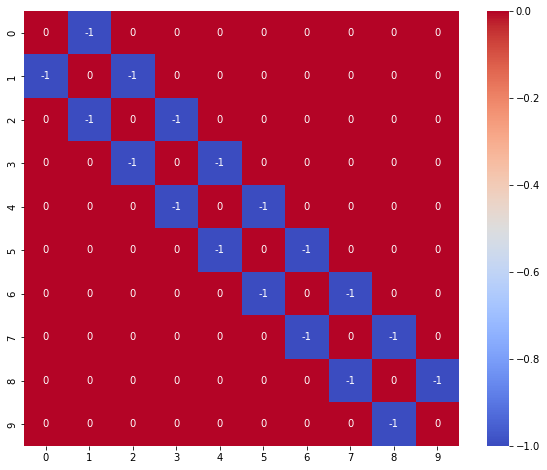

In [138]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()


In [139]:
# H_1 = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()a
# plt.close()
# H_2 = mat

In [141]:

# mat_out = H_1# + H_2
# mat_dense = mat_out.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# # plot_coo_matrix(mat_out)
# # plt.savefig("hmm.pdf")

<AxesSubplot:>

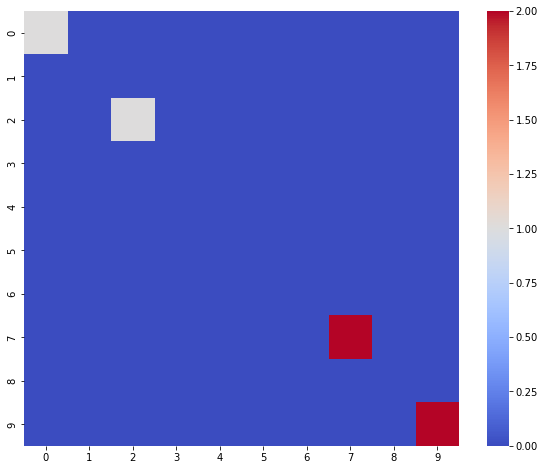

In [98]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

<AxesSubplot:>

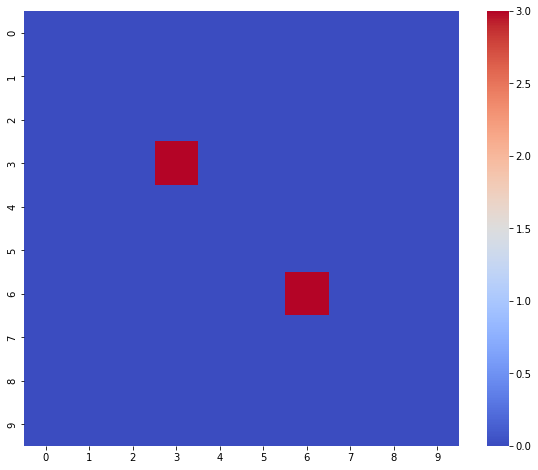

In [99]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

<AxesSubplot:>

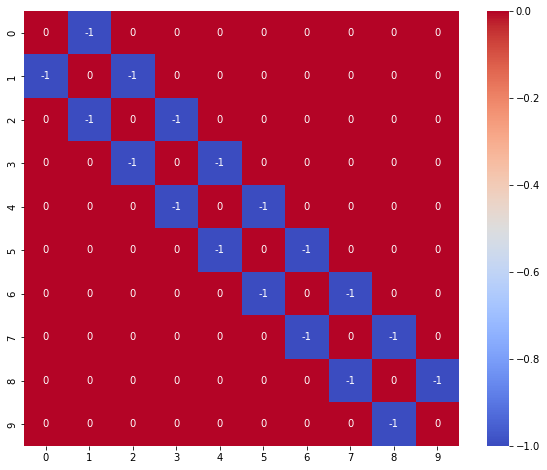

In [144]:
plt.figure(figsize=(10,8))
# mat_res = mat_out_int+mat_out
H_tot = (mat.toarray())
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
# print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

In [102]:
H_tot

array([[ 1.        , -1.41421356,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.41421356,  0.        , -1.41421356,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.41421356,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.        , -1.        ,
        -1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        , -1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        , -1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.        ,
        -1.        ,  3.        ,  0.        

In [ ]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

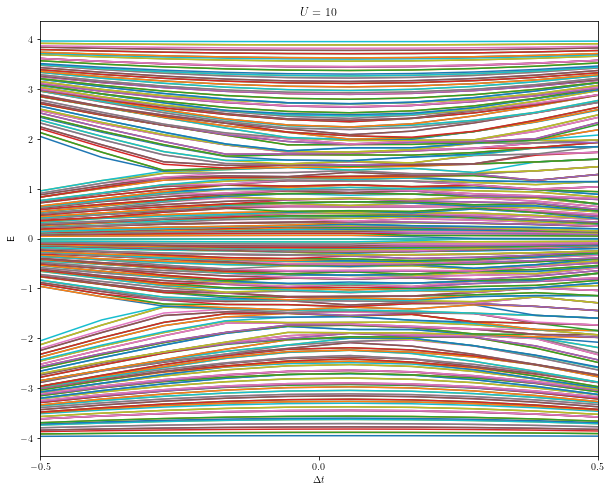

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
# plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

---
---
---

In [150]:
# N - Number of particles in a system
# N = np.array([2])  # If number - the same number for both systems
N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 10
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([0, 0])
# Statistic (bose/fermi)
# stat = np.array(['b'])  # If single - the same statistic in both
stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [151]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

(100, 20)

In [152]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 351 µs, sys: 389 µs, total: 740 µs
Wall time: 731 µs


In [153]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()
# plt.close()
H_1 = mat

In [154]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# plt.figure(figsize=(10,8))
# sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
# plt.show()
# plt.close()
H_2 = mat

In [155]:
mat_out = H_1 + H_2
mat_dense = mat_out.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

In [156]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

In [157]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

In [158]:
# plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense+mat_inter_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

U_aa = 0, U_bb = 0, U_ab=0, J = 1


In [174]:
# # First tab - values, last two tabs - coordinates
# H_kin_prep = [List(), List(), List()]
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
# # Output data type is A list of typed lists from Numba, for the function to be JIT-compilable
# # H_kin_prep;
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out = mat
# H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
# mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
# mat_out += mat
# mat_dense = mat_out.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_out)

# First tab - values, last two tabs - coordinates
# H_int_prep = [List(), List(), List()]
# H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
# # H_int_prep;
# mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
# mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
# mat_out_int += mat_int
# mat_int_dense = mat_out_int.toarray()
# plt.figure(figsize=(10,8))
# sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)

H_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
H_inter = sc.sparse.coo_matrix((H_inter[0], (H_inter[1], H_inter[2])), shape=(D, D))
# mat_inter_dense = mat_inter.toarray()
# # plt.figure(figsize=(10,8))
# # sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# # plot_coo_matrix(mat_inter)

# mat_res = mat_out_int+mat_out#+mat_inter
t_tab = np.linspace(-0.9, 0.9, 20)
res_dict = {}
vecs_dict = {}
# fig, ax = plt.subplots(1, 10, figsize=(80,8), sharey=True)

Evals1_matrix = np.zeros((t_tab.shape[0],H_inter.shape[0]))
Evals2_matrix = np.zeros((t_tab.shape[0],H_inter.shape[0]))

for t_i in range(0,t_tab.shape[0]):
    t_var = t_tab[t_i]
    print(r"d_t = ", t_var)
    H_kin_prep = [List(), List(), List()]
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
    H_1 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=t_var, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
    H_2 = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    H_out =  H_1 + H_2

    mat_res = H_out+H_inter#+mat_out_int

    
    # ax[num] = plot_coo_matrix(H_out)
    # sns.heatmap(np.matrix(H_out.toarray()), square=True, cmap=/'coolwarm', annot=False, ax=ax[num], cbar=False)

    # res_dict[t_var] = sc.sparse.linalg.eigsh(mat_res, k=100, return_eigenvectors=False, which='SM')
    vals, vecs = np.linalg.eigh(mat_res.toarray())
    # vals, vecs = sc.linalg.eigh(mat_res.toarray(), eigvals_only=False)
    idx = np.argsort(vals,-1)
    vecs = vecs[:,idx]
    vals = vals[idx]
    evecs_dt = []
    evals_dt = []
    for e_vec_i in range(0, vals.shape[0]):
        psi = vecs[:, e_vec_i]
        e_i = vals[e_vec_i]
        exp_val_H_1 = np.dot(np.conjugate(psi), np.dot(H_1.toarray(), psi))
        exp_val_H_2 = np.dot(np.conjugate(psi), np.dot(H_2.toarray(), psi))
        Evals1_matrix[t_i,e_vec_i] = exp_val_H_1
        Evals2_matrix[t_i,e_vec_i] = exp_val_H_2
        # evecs_dt.append()
        print("dt = {}, i = {}, E_1 = {}, E_2 = {}, eval_i = {}".format(t_var, e_vec_i, exp_val_H_1, exp_val_H_2, e_i))
 



# plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
# sns.heatmap(np.matrix((mat_int_dense+mat_dense+mat_inter_dense)), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))

d_t =  -0.9
dt = -0.9, i = 0, E_1 = -1.9870289313713185, E_2 = -1.9870289313713183, eval_i = -3.974057862742639
dt = -0.9, i = 1, E_1 = -1.9691615981401507, E_2 = -1.9691615981401513, eval_i = -3.9383231962803023
dt = -0.9, i = 2, E_1 = -1.9691615981401507, E_2 = -1.969161598140151, eval_i = -3.9383231962803005
dt = -0.9, i = 3, E_1 = -1.9512942649089817, E_2 = -1.951294264908982, eval_i = -3.902588529817967
dt = -0.9, i = 4, E_1 = -1.944391478677054, E_2 = -1.9443914786745682, eval_i = -3.8887829573516206
dt = -0.9, i = 5, E_1 = -1.9443914786745697, E_2 = -1.9443914786770546, eval_i = -3.888782957351619
dt = -0.9, i = 6, E_1 = -1.926524145439684, E_2 = -1.9265241454495992, eval_i = -3.8530482908892854
dt = -0.9, i = 7, E_1 = -1.9265241454496, E_2 = -1.9265241454396853, eval_i = -3.8530482908892827
dt = -0.9, i = 8, E_1 = -1.9191832361900254, E_2 = -1.9191832370223982, eval_i = -3.838366473212419
dt = -0.9, i = 9, E_1 = -1.919183237022395, E_2 = -1.9191832361900216, eval_i = -3.8383664

In [175]:
Evals1_matrix.shape


(20, 100)

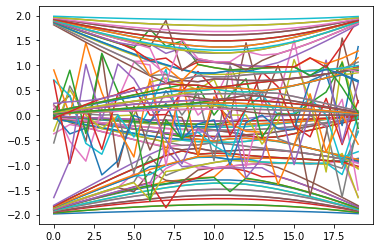

In [176]:
fig = plt.figure()
for i in range(0,Evals1_matrix.shape[1]):
    plt.plot(Evals1_matrix[:,i])


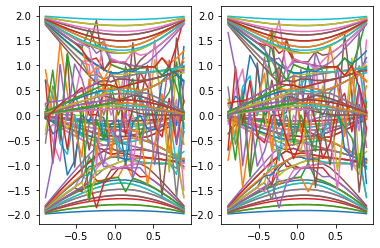

In [177]:
figs, ax = plt.subplots(1,2)
for i in range(0,Evals1_matrix.shape[1]):
    ax[0].plot(t_tab, Evals1_matrix[:,i])
    ax[1].plot(t_tab, Evals2_matrix[:,i])


In [66]:
plot_dict = {}
for i in range(len(res_dict[-0.5])):
    plot_dict[i] = []
    for key in res_dict.keys():
        plot_dict[i].append(res_dict[key][i])

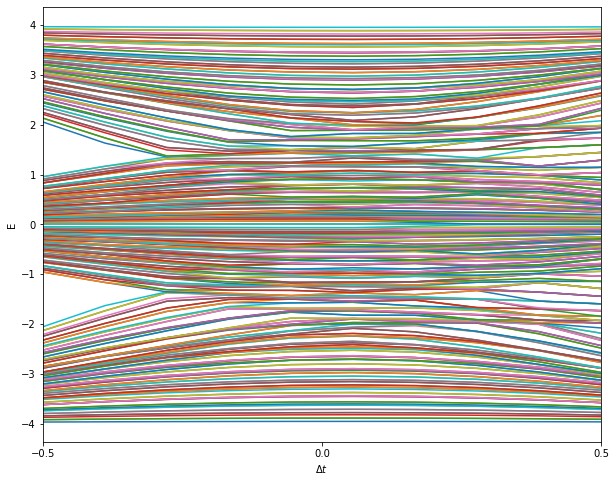

In [67]:
plt.figure(figsize=(10,8))
for i in range(len(res_dict[-0.5])):
    plt.plot(t_tab, np.real(plot_dict[i]))
# plt.ylim(-4, 0)
plt.xlim(-0.5,0.5)
plt.xticks([-0.5, 0, 0.5])
# plt.title("$U=10$")
plt.xlabel("$\Delta t$")
plt.ylabel("E")
plt.savefig("Highly correlated spectrum.pdf")
plt.show()

In [42]:
# sym.Matrix(H_1.toarray())

<AxesSubplot:>

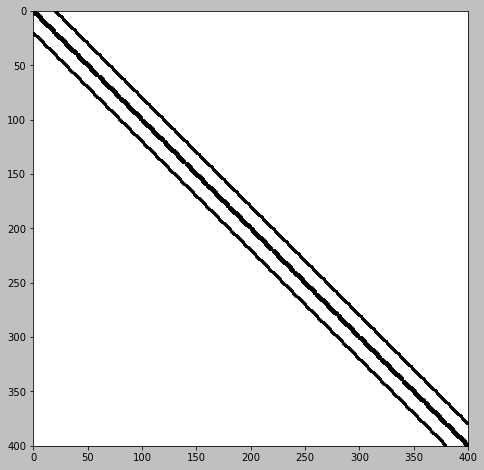

In [46]:
plot_coo_matrix(H_tot)

In [135]:
ee, ev = np.linalg.eigh(H_tot)
ee1, ev1 = np.linalg.eigh(H_1.toarray())
ee2, ev2 = np.linalg.eigh(H_2.toarray())

In [129]:
ev

array([[-0.5       ,  0.02520116,  0.70665756, -0.5       ],
       [-0.5       , -0.70665756,  0.02520116,  0.5       ],
       [-0.5       ,  0.70665756, -0.02520116,  0.5       ],
       [-0.5       , -0.02520116, -0.70665756, -0.5       ]])

In [121]:
ge = ee[0]
ge

-1.9999999999999998

In [127]:
gs = ev[0]
gs

array([-0.5       ,  0.02520116,  0.70665756, -0.5       ])

In [132]:
exp_tot = np.dot(gs.T, np.dot(H_tot, gs))
exp_up = np.dot(gs.T, np.dot(H_1.toarray(), gs))
exp_down = np.dot(gs.T, np.dot(H_2.toarray(), gs))

In [133]:
print("<H_tot> = {}, <H_up> = {}, <H_down> = {}, <H_up> + <H_down> - <H_tot> = {}".format(exp_tot, exp_up, exp_down, exp_up+exp_down-exp_tot))

<H_tot> = 1.4637174284652699, <H_up> = 0.7318587142326349, <H_down> = 0.7318587142326348, <H_up> + <H_down> - <H_tot> = 0.0


In [155]:
sym.Matrix(H_tot)

Matrix([
[   0, -1.0, -1.0,    0],
[-1.0,    0,    0, -1.0],
[-1.0,    0,    0, -1.0],
[   0, -1.0, -1.0,    0]])

In [ ]:
for en, en1, en2 in zip(ee, ee1, ee2):
    print("e = {:+4.2f}, e_1 = {:+4.2f}, e_2 = {:+4.2f}, e_diff = {:+4.2f}".format(en, en1, en2, abs(en1+en2-en)))

e = -2.00, e_1 = -1.00, e_2 = -1.00, e_diff = +0.00
e = -0.00, e_1 = -1.00, e_2 = -1.00, e_diff = +2.00
e = +0.00, e_1 = +1.00, e_2 = +1.00, e_diff = +2.00
e = +2.00, e_1 = +1.00, e_2 = +1.00, e_diff = +0.00


---
---
---

#### Benchmark - 2comp BH

In [262]:
# N - Number of particles in a system
# N = np.array([2])  # If number - the same number for both systems
N = np.array([2, 2])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = 1
# U - On-site potential scaling factor
# U = np.array([0])
U = np.array([2, 2])
# Statistic (bose/fermi)
# stat = np.array(['b'])  # If single - the same statistic in both
stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 4
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 1

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [263]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

(100, 8)

In [264]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 337 µs, sys: 261 µs, total: 598 µs
Wall time: 593 µs


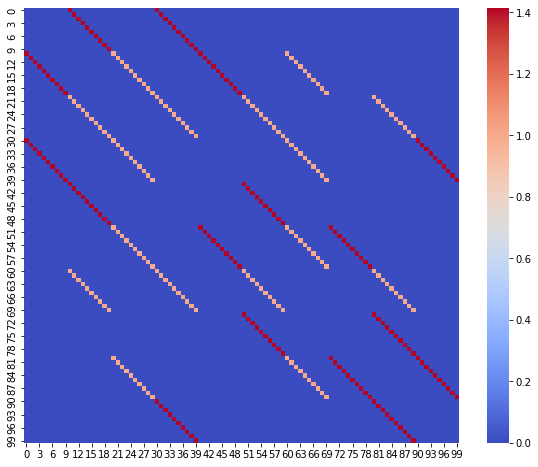

In [265]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=False)
plt.show()
plt.close()
H_1 = mat

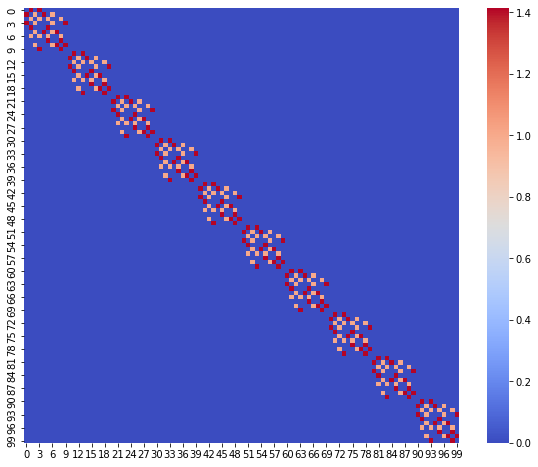

In [266]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[1], component_count=component_count, component_no=1)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=False)
plt.show()
plt.close()
H_2 = mat

<AxesSubplot:>

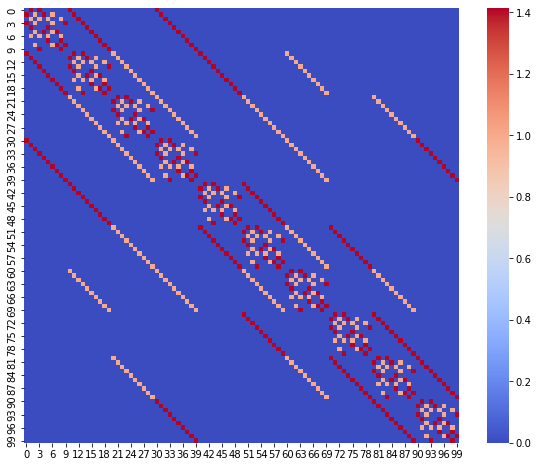

In [267]:
mat_out = H_1 + H_2
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

<AxesSubplot:>

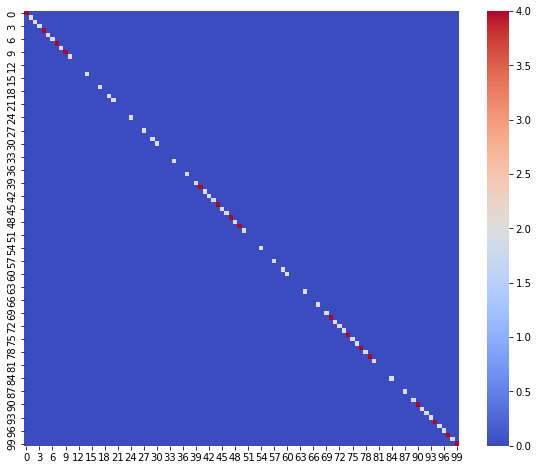

In [268]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
H_int_prep;
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
H_int_prep = get_interactions_H(A, M, U[1], t_dict, statistic=stat[1], component_count=component_count, component_no=1)
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_out_int += mat_int
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

<AxesSubplot:>

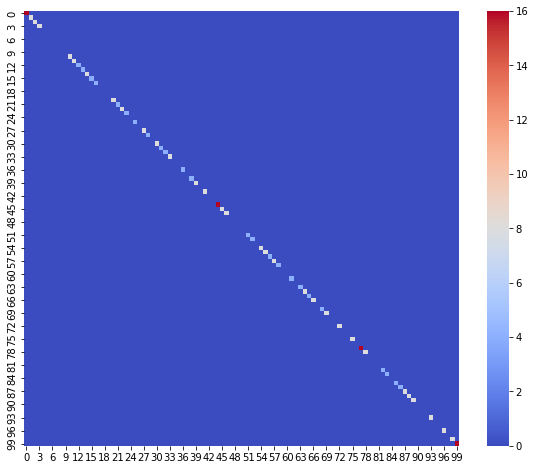

In [269]:
mat_inter = get_intercomp_interactions_H(A, M, V, t_dict, statistic=stat, component_count=component_count)
mat_inter;
mat_inter = sc.sparse.coo_matrix((mat_inter[0], (mat_inter[1], mat_inter[2])), shape=(D, D))
mat_inter_dense = mat_inter.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_inter_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_inter)

U_aa = 2, U_bb = 2, U_ab=4, J = 1


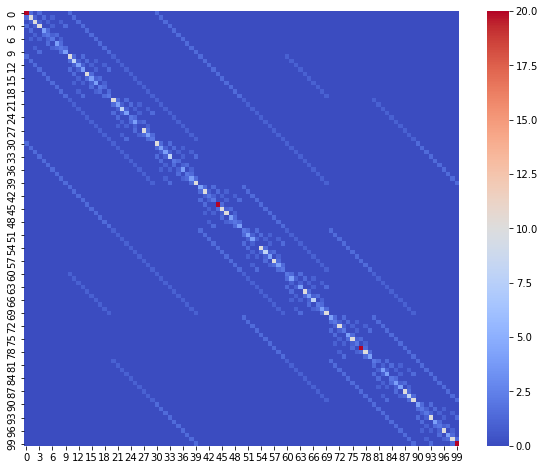

In [270]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense+mat_inter_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=False)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U_aa = {}, U_bb = {}, U_ab={}, J = {}".format(U[0], U[1], V, abs(J)))

In [271]:
mat_ver = np.load("H_bosons_double_comp.npy")

<AxesSubplot:>

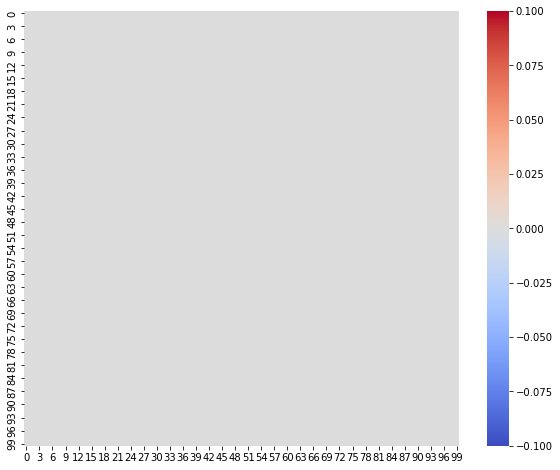

In [272]:
plt.figure(figsize=(10,8))
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(mat_ver-H_tot, square=True, cmap='coolwarm', annot=False)

In [191]:
m = sym.Matrix(H_tot)
# m

---
---
---

#### Benchmark - FH

In [159]:
# N - Number of particles in a system
N = np.array([2])  # If number - the same number for both systems
# N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = np.array([2])
# U = np.array([0, 0])
# Statistic (bose/fermi)
stat = np.array(['f'])  # If single - the same statistic in both
# stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [160]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

(6, 4)

In [161]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 377 µs, sys: 850 µs, total: 1.23 ms
Wall time: 1.69 ms


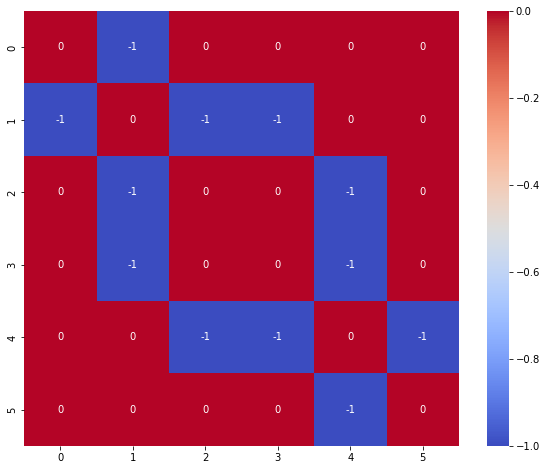

In [162]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()
H_1 = mat

<AxesSubplot:>

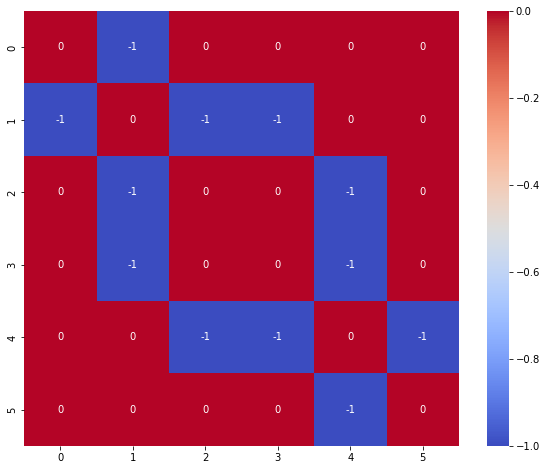

In [168]:
mat_out = H_1
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

<AxesSubplot:>

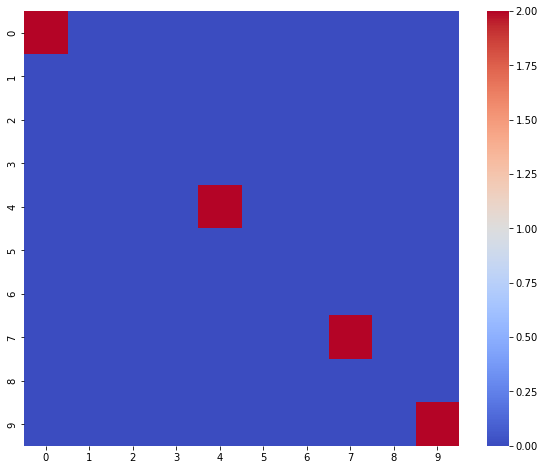

In [209]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count, component_no=0)
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

U = 2, J = 1


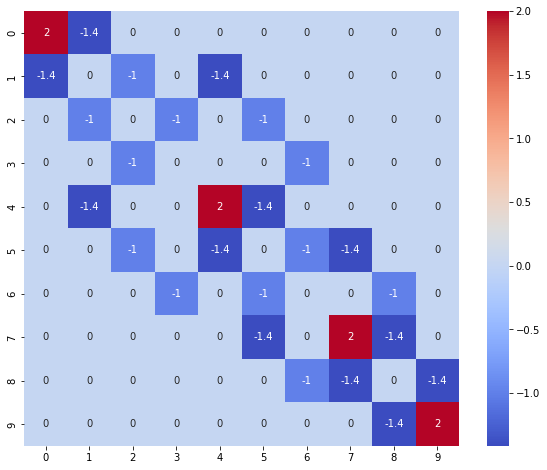

In [210]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U = {}, J = {}".format(U[0], abs(J)))

---
---
---

#### Benchmark - BH

In [203]:
# N - Number of particles in a system
N = np.array([2])  # If number - the same number for both systems
# N = np.array([1, 1])  # If list - [n_1, n_2] - subsystem sizes
# 
# M - Number of sites to fill
M = 4
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = np.array([2])
# U = np.array([0, 0])
# Statistic (bose/fermi)
stat = np.array(['b'])  # If single - the same statistic in both
# stat = np.array(['b', 'b']) # If list - [stat_1, stat_2] - subsystem statistics
# Staggering - SSH parameter
delta_t = 0.0
# Intercomponent interaction strength
V = 0
# Number of basis vector components
component_count = 1
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_dim_tab(M, N, stat_tab=stat)
# D = 10

In [204]:
A = get_tensor_basis(M, N, statistic=stat, component_count=component_count, verb=0)
A.shape
# A = np.array([
#     [2,0,0,0],
#     [1,1,0,0],
#     [0,2,0,0],
#     [1,0,1,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [0,1,0,1],
#     [0,0,2,0],
#     [0,0,1,1],
#     [0,0,0,2]
# ])

(10, 4)

In [205]:
%%time
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 183 µs, sys: 10 µs, total: 193 µs
Wall time: 189 µs


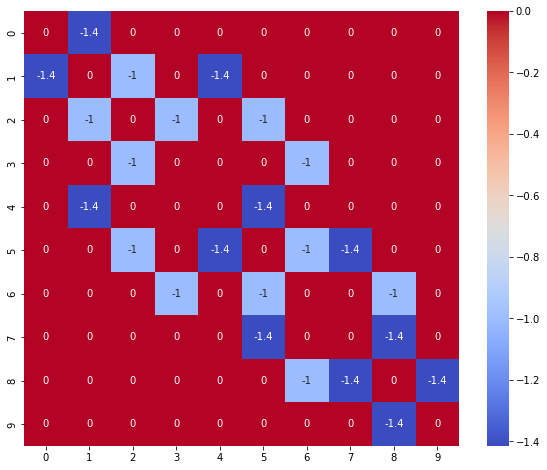

In [206]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]
H_kin_prep = get_kinetic_H(A, M, J, t_dict, delta_t=delta_t, pbc=pbc, statistic=stat[0], component_count=component_count, component_no=0)
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
plt.figure(figsize=(10,8))
sns.heatmap(mat.toarray(), square=True, cmap='coolwarm', annot=True)
plt.show()
plt.close()
H_1 = mat

<AxesSubplot:>

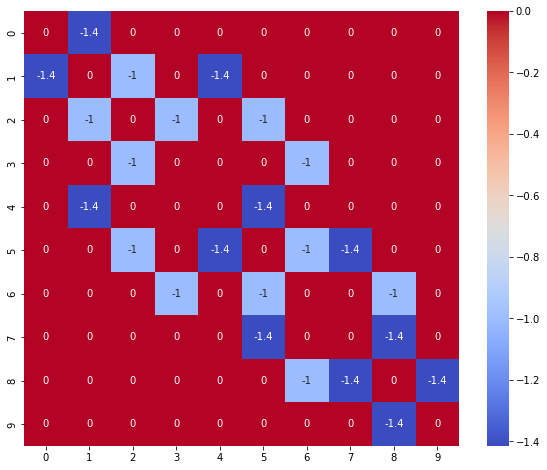

In [207]:
mat_out = H_1
mat_dense = mat_out.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out)
# plt.savefig("hmm.pdf")

<AxesSubplot:>

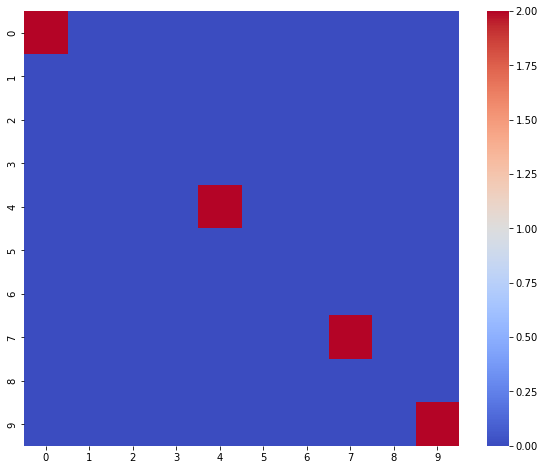

In [211]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]
H_int_prep = get_interactions_H(A, M, U[0], t_dict, statistic=stat[0], component_count=component_count)
mat_out_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))
mat_int_dense = mat_out_int.toarray()
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')
# plot_coo_matrix(mat_out_int)
# plt.savefig("hmm.pdf")

U = 2, J = 1


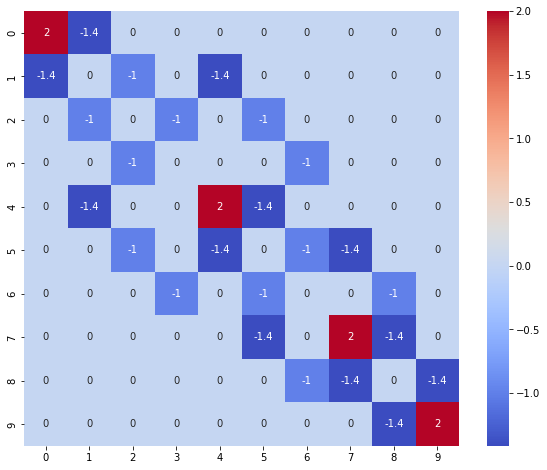

In [212]:
plt.figure(figsize=(10,8))
mat_res = mat_out_int+mat_out
H_tot = (mat_int_dense+mat_dense)
# plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix(H_tot), square=True, cmap='coolwarm', annot=True)
# plot_coo_matrix(mat_out_int+mat_out+mat_inter, title="N = {}, L = {}, dim = {}".format(N, M, D))
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))
print("U = {}, J = {}".format(U[0], abs(J)))